# **Early Analysis & Insights For Fair Use Cases Data**

**Project Milestone 2**

**Team:** B1 Team 13

**Team Member:** Mohamad Gong

# Introduction

## Introduction

This project analyzes a public dataset of U.S. fair use decisions collected from the U.S. Copyright Office’s Fair Use Index and distributed via TidyTuesday. Data and documentation are available here:
https://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-08-29

Copyright claims can be used to pressure people into removing lawful criticism, commentary, and educational content because disputes are costly and uncertain. Unclear fair use boundaries also harm good-faith creators by weakening protection of original work and income; high-profile disputes such as *Lenz v. Universal* and *Warhol Foundation v. Goldsmith* illustrate ongoing uncertainty around fair use and “transformative” use. Our broader goal is to use unsupervised learning to surface repeatable patterns across cases and make precedent easier to navigate, supporting decisions to push back, license, or escalate. Key stakeholders include creators and small businesses, media and education organizations, platforms and policy teams handling disputes at scale, and legal, insurance, and advocacy groups.

The dataset contains written summaries of each case’s key facts, the fair use issue, and the court’s holding, along with tags and structured metadata. In the team’s proposal, we noted that merges across tables can be unreliable because case identifiers are not standardized; accordingly, this notebook focuses on the `fair_use_findings` table as the primary analysis unit.

This notebook addresses the team’s Question 2, venue fairness after controlling for dispute type. Specifically, after grouping cases into comparable case types using tags, categories, and recurring text themes, do some courts or circuits remain consistently more creator-friendly versus rightsholder-friendly for the same case type? This matters because it separates true venue effects from case-mix effects, informing forum strategy, budgeting and risk forecasts, and whether organizations should adjust compliance posture in certain jurisdictions.

Prior EDA suggested that outcomes are imbalanced, the dataset is dominated by a few courts and circuits, and tags may mix what the case is about with where it was decided. The text fields also vary substantially in length, and legal language can be generic, so the analysis emphasizes text features that separate cases by facts and themes rather than boilerplate.

The sections that follow first present updated EDA for `fair_use_findings`, including outcome distributions and tag and category structure. The notebook then applies unsupervised text methods to extract dispute themes and group cases into comparable case types, and finally compares fair use outcomes across venues within those types.

# Setting Up Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Data Importing, Inspection and Preparation

## Data Importing

In [2]:
fair_use_cases = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_cases.csv')
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

### Fair Use Cases Table

The `fair_use_cases` table provides one row per case with structured metadata such as year, court, jurisdiction, content categories, and a binary indicator for whether fair use was found. Inspection focuses on confirming completeness, consistency of categorical fields, and suitability for comparing outcomes across courts, categories, and time.

| variable       | class     | description                                                                                                   |
| -------------- | --------- | ------------------------------------------------------------------------------------------------------------- |
| case           | character | The name and number of the case.                                                                              |
| year           | integer   | The year in which the case was decided.                                                                       |
| court          | character | The court in which the ruling was made.                                                                       |
| jurisdiction   | character | The jurisdiction of that court.                                                                               |
| categories     | character | A comma- or semicolon-separated list of categories to which the case belongs. These have not been normalized. |
| outcome        | character | A string describing the outcome of the case.                                                                  |
| fair_use_found | logical   | Whether fair use was found by the court. FALSE might sometimes indicate a more complicated finding.           |

In [3]:
print("Dataset Info:")
print(fair_use_cases.info())

print("\nFirst 5 rows:")
print(fair_use_cases.head())

print("\nMissing Values:")
print(fair_use_cases.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   case            251 non-null    object
 1   year            251 non-null    int64 
 2   court           251 non-null    object
 3   jurisdiction    251 non-null    object
 4   categories      251 non-null    object
 5   outcome         251 non-null    object
 6   fair_use_found  251 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 12.1+ KB
None

First 5 rows:
                                                case  year        court  \
0  De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....  2022  9th Circuit   
1  Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...  2022    C.D. Cal.   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...  2022     S.D.N.Y.   
3  Am. Soc'y for Testing & Materials v. Public.Re...  2022       D.D.C.   
4  Yang v. Mic Network Inc., No

### Fair Use Findings Table

The `fair_use_findings` table contains complementary case-level text, including summaries of key facts, legal issues, holdings, and descriptive tags. Inspection centers on text completeness and variability, as these fields support later analysis of language patterns, similarity, and thematic structure across cases.

| variable    | class     | description                                                                            |
| ----------- | --------- | -------------------------------------------------------------------------------------- |
| title       | character | The title of the case.                                                                 |
| case_number | character | The case number or numbers of the case.                                                |
| year        | character | The year in which the finding was made (or findings were made).                        |
| court       | character | The court or courts involved.                                                          |
| key_facts   | character | The key facts of the case.                                                             |
| issue       | character | A brief description of the fair use issue.                                             |
| holding     | character | The decision of the court in paragraph form.                                           |
| tags        | character | Comma- or semicolon-separated tags for this case.                                      |
| outcome     | character | A brief description of the outcome of the case. These fields have not been normalized. |

In [4]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

### Choosing the Working Analysis Table

After importing and inspecting `fair_use_cases` and `fair_use_findings`, both tables appear to contain the same number of rows and to be intended as two views of the same set of cases. The fields are partitioned differently across the two tables, but much of the information overlaps. For this notebook, `fair_use_findings` is used as the primary analysis table because it contains the richest information for unstructured methods, especially the detailed text fields.

Key overlap and differences:

- **Identifiers:** `fair_use_findings` provides `title` and `case_number`, which together serve the same purpose as the single `case` identifier column in `fair_use_cases`. Splitting identifiers into separate fields is convenient for readability, but these columns are not analytical features and are mainly used for reference.
- **Year:** the `year` field is present in both tables.
- **Court information:** `fair_use_cases` includes `court` and `jurisdiction`, while `fair_use_findings` includes `court`. These fields provide overlapping venue information, and a single court or venue field is sufficient for the planned analysis.
- **Labels and outcomes:** both tables include an `outcome` column describing the fair use result at a high level.
- **Text fields (unique to `fair_use_findings`):** `key_facts`, `issue`, and `holding` provide detailed narrative summaries that support text-based unsupervised analysis (topic modeling, similarity, and text-derived case types). These columns are the main reason `fair_use_findings` is preferred.
- **Outcome labeling:** `fair_use_findings` does not include a boolean `fair_use_found`, so an outcome label is derived from the `outcome` text. Outcomes are standardized and mapped into three groups: **fair use found**, **fair use not found**, and **indeterminate** (preliminary, mixed, remand, or unclear).

Although the documentation notes that the rows are aligned across the two tables, the values do not reliably support a clean join in practice because case identifiers are not standardized (for example, citation text, punctuation, abbreviations, and formatting differences). As a quick validation step, a direct join was attempted by reconstructing the `case` identifier from `title` and `case_number`. This matched only **30 of 251 records (12.0%)** when checking whether text fields were successfully pulled in.

Improving this join would require record linkage methods (such as fuzzy matching or NLP-based similarity) and manual verification to avoid incorrect merges. Since the tables are largely redundant for shared metadata and `fair_use_findings` already contains the key unstructured fields needed for this milestone, `fair_use_findings` is used alone rather than relying on a merged table.

#### Joining Attempt

The two files describe the same cases, so the first merge attempt is to recreate the `case` string in `fair_use_findings` by combining `title` and `case_number`, then merge on `case`. After merging, the match rate is checked to see how many rows successfully pulled in text fields.

In [18]:
fair_use_cases["case"] = fair_use_cases["case"].astype(str).str.strip()

fair_use_findings["case"] = (
    fair_use_findings["title"].astype(str).str.strip()
    + ", "
    + fair_use_findings["case_number"].astype(str).str.strip()
)

fair_use_merged = fair_use_cases.merge(
    fair_use_findings.drop(columns=["title", "case_number", "year", "court", "outcome"]),
    on="case",
    how="left"
)

joined = fair_use_merged["key_facts"].notna().sum()
total = len(fair_use_merged)
print(f"Joined rows: {joined} / {total} ({joined/total:.1%})")

# Drop column "case"
fair_use_findings.drop(columns=["case"], inplace=True)

Joined rows: 30 / 251 (12.0%)


In practice, many rows do not join because the identifiers are not standardized. For example, `case_number` in the findings table often includes extra citation text (like Westlaw or LEXIS), and case names can differ in punctuation or abbreviations (for example “v.” vs “vs”, “Inc.” vs “Inc”). Fixing this reliably usually needs record linkage methods such as fuzzy matching or NLP-based similarity. Because of that, the EDA treats the two tables separately, and a more advanced merge can be added later if a single combined table is required.

## Preparing Data

### Outcome Flag Construction

The outcome column is converted into a simple label for analysis. The text is cleaned and then grouped into three outcomes: fair use found, fair use not found, and indeterminate (preliminary, mixed, remand, or unclear). A binary fair_use_found flag is created only for the final outcomes, and indeterminate cases are left out of binary rate calculations.

In [20]:
# Count outcome column from fair_use_findings and reset index
outcome_counts = fair_use_findings["outcome"].value_counts().reset_index()
outcome_counts.columns = ["outcome", "count"]

# Display the counts
print(outcome_counts)

                                   outcome  count
0                       FAIR_USE_NOT_FOUND    100
1                           FAIR_USE_FOUND    100
2                            INDETERMINATE     42
3  Preliminary finding; fair use not found      3
4                             Mixed result      2
5   Preliminary ruling, fair use not found      2
6   Fair use not found, Preliminary ruling      1
7                       Fair Use Not Found      1


Based on the grouped outcome counts, outcomes fall into three clear categories. Entries labeled “Fair use found” (including minor punctuation or appeal notes) are treated as fair use found, and entries labeled “Fair use not found” (including punctuation variants) are treated as fair use not found. All remaining outcomes, such as preliminary rulings, mixed results, remands, and irregular text entries, are treated as indeterminate. A binary fair_use_found flag is then defined only for the final outcomes, while indeterminate cases are excluded from binary rate calculations.

In [21]:
outcome_map = {
    # FINAL: fair use found
    "Fair use found": "FAIR_USE_FOUND",
    "Fair use found.": "FAIR_USE_FOUND",
    "Fair use found; Second Circuit affirmed on appeal.": "FAIR_USE_FOUND",

    # FINAL: fair use not found
    "Fair use not found": "FAIR_USE_NOT_FOUND",
    "Fair use not found.": "FAIR_USE_NOT_FOUND",

    # INDETERMINATE
    "Mixed Result": "INDETERMINATE",
    "Fair Use Found; mixed result": "INDETERMINATE",
    "Preliminary ruling, fair use found": "INDETERMINATE",
    "Fair use not found, preliminary ruling": "INDETERMINATE",
    "Fair use not found; Preliminary ruling": "INDETERMINATE",
    "Preliminary finding; Fair use not found": "INDETERMINATE",
    "Preliminary ruling, Fair use not found": "INDETERMINATE",
    "Preliminary ruling, fair use not found, mixed result": "INDETERMINATE",
    "Preliminary ruling, mixed result, or remand": "INDETERMINATE",
    "Preliminary ruling, remand": "INDETERMINATE",
    "Preliminary ruling; Fair use not found": "INDETERMINATE",
    "Plaintiff Patrick Cariou published Yes Rasta, a book of portraits and landscape photographs taken in Jamaica. Defendant Richard Prince was an appropriation artist who altered and incorporated several of plaintiff’s photographs into a series of paintings and collages called Canal Zone that was exhibited at a gallery and in the gallery’s exhibition catalog. Plaintiff filed an infringement claim, and the district court ruled in his favor, stating that to qualify as fair use, a secondary work must “comment on, relate to the historical context of, or critically refer back to the original works.” Defendant appealed.": "INDETERMINATE",
}

In [22]:
# Replace outcome column values with the mapping in outcome_map
fair_use_findings["outcome"] = fair_use_findings["outcome"].replace(outcome_map)

### Transforming Tags Column

The tags column stores multiple labels in one string. To make it usable, the text is standardized (lowercased and stripped) and then split into a list of tags per case. The split handles both semicolons and commas since both appear in the data.

In [27]:
df = fair_use_findings.copy()

df["tags_list"] = (
    df["tags"].astype(str)
    .str.lower()
    .str.replace(".", "", regex=False)
    .str.split(r"[;,]")  # split on ; or ,
    .apply(lambda xs: [t.strip() for t in xs if t.strip()])
)

After converting tags into lists, each unique tag is converted into a separate binary feature using one-hot encoding. This creates a tag-feature matrix where 1 means the case contains that tag and 0 means it does not.

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tags_ohe = pd.DataFrame(
    mlb.fit_transform(df["tags_list"]),
    columns=mlb.classes_,
    index=df.index
)

print("Rows:", tags_ohe.shape[0])
print("Unique tags:", tags_ohe.shape[1])

# Print tags_ohe as columns
print(tags_ohe.columns)

Rows: 251
Unique tags: 39
Index(['computer program', 'district of columbia circuit',
       'education/research/scholarship', 'education/scholarship/research',
       'educational/scholarship/research', 'eighth circuit',
       'eleventh circuit', 'federal circuit', 'fifth circuit',
       'film/audiovisual', 'films/audiovisual', 'first circuit',
       'format shifting/space shifting', 'fourth circuit', 'internet',
       'internet/digitization', 'mixed result', 'music', 'news reporting',
       'ninth circuit', 'or remand', 'other', 'painting/drawing/graphic',
       'parody', 'parody/satire', 'photograph', 'photography',
       'preliminary ruling', 'review/commentary', 'sculpture',
       'second circuit', 'seventh circuit', 'sixth circuit', 'tenth circuit',
       'textual work', 'third circuit', 'unpublished', 'us supreme court',
       'used in government proceeding'],
      dtype='object')


For the venue fairness question, venue information should not be used to define “case types.” Some tags directly encode venue (for example, circuit names). To avoid leakage, these venue-related tag columns are removed from the one-hot tag matrix before clustering.

In [34]:
venue_keywords = ["circuit", "district", "supreme court"]

venue_cols = [c for c in tags_ohe.columns if any(k in c for k in venue_keywords)]
tags_ohe_case_type = tags_ohe.drop(columns=venue_cols)

print("Venue tag columns removed:", len(venue_cols))
print("Remaining tag features:", tags_ohe_case_type.shape[1])

# Print tags_ohe as columns
print(tags_ohe_case_type.columns)

Venue tag columns removed: 14
Remaining tag features: 25
Index(['computer program', 'education/research/scholarship',
       'education/scholarship/research', 'educational/scholarship/research',
       'film/audiovisual', 'films/audiovisual',
       'format shifting/space shifting', 'internet', 'internet/digitization',
       'mixed result', 'music', 'news reporting', 'or remand', 'other',
       'painting/drawing/graphic', 'parody', 'parody/satire', 'photograph',
       'photography', 'preliminary ruling', 'review/commentary', 'sculpture',
       'textual work', 'unpublished', 'used in government proceeding'],
      dtype='object')


### Column Cleaning Steps

The `year` column is converted to a numeric integer format to ensure it can be used reliably in grouping, filtering, and any downstream modeling steps. Any non-numeric or missing values are handled safely during conversion.

In [40]:
# Turn the year column to integer
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

Some columns are not needed for the planned analysis. The `title` column is an identifier and will not be used as a feature, and the `holding` column is excluded to avoid leaking decision language into case-type construction. These columns are dropped to keep the working dataset focused.

In [41]:
# Drop title and holding columns
df.drop(columns=["title", "holding"], inplace=True)

In [43]:
fair_use_findings_clean = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   case_number  251 non-null    object
 1   year         250 non-null    Int64 
 2   court        251 non-null    object
 3   key_facts    251 non-null    object
 4   issue        251 non-null    object
 5   tags         251 non-null    object
 6   outcome      251 non-null    object
 7   tags_list    251 non-null    object
dtypes: Int64(1), object(7)
memory usage: 16.1+ KB


# Exploratory Data Analysis (EDA)

## Part 1: Outcome Profile and Historical Shifts

This section checks the overall balance of outcomes and whether the fair use finding rate changes over time, which can hint at shifts in how cases are decided or what kinds of cases appear in different periods.

In [59]:
fair_use_cases["fair_use_found"].value_counts(dropna=False).to_frame("count")

,count
fair_use_found,
False,150
True,101


Most cases end with fair use not found (150) compared with fair use found (101), so the outcome variable is somewhat imbalanced and later comparisons should keep that baseline in mind.

In [60]:
by_year = (fair_use_cases.groupby("year")
           .agg(n_cases=("fair_use_found", "size"),
                fair_use_found_rate=("fair_use_found", "mean"))
           .reset_index())

by_year

,year,n_cases,fair_use_found_rate
0,1841,1,0.000000
1,1950,1,0.000000
2,1956,1,0.000000
3,1957,1,1.000000
4,1962,1,0.000000
5,1964,1,1.000000
6,1966,1,0.000000
7,1973,1,1.000000
8,1976,1,0.000000
9,1977,2,0.500000


The fair use rate varies a lot across years, with many years showing extreme values like 0.0 or 1.0, which strongly suggests small sample sizes per year and makes single-year rates noisy.

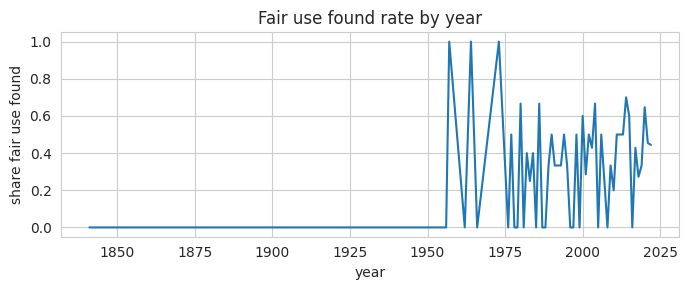

In [61]:
plt.figure(figsize=(7,3))
plt.plot(by_year["year"], by_year["fair_use_found_rate"])
plt.title("Fair use found rate by year")
plt.xlabel("year")
plt.ylabel("share fair use found")
plt.tight_layout()
plt.show()

The chart visualizes the same pattern: early years have sharp spikes because there are few observations, while later years show frequent ups and downs but generally sit in a mid-range band rather than staying consistently high or low.

## Part 2: Decision Venue Footprint

This section summarizes which courts and jurisdictions appear most often, since concentration in a few courts can shape the overall patterns and may reveal places where outcomes differ.

In [62]:
fair_use_cases["court"].value_counts().head(10).to_frame("count")

,count
court,
S.D.N.Y.,47
2d Circuit,45
9th Circuit,34
C.D. Cal.,17
11th Circuit,8
4th Circuit,7
7th Circuit,7
D. Nev.,5
U.S. Supreme Court,5


Cases are concentrated in a few courts, led by S.D.N.Y. (47), 2d Circuit (45), and 9th Circuit (34), with a noticeable drop after the top three.

In [63]:
fair_use_cases["jurisdiction"].value_counts().head(10).to_frame("count")

,count
jurisdiction,
2nd Circuit,98
9th Circuit,64
11th Circuit,13
7th Circuit,12
4th Circuit,11
5th Circuit,10
1st Circuit,9
6th Circuit,9
3rd Circuit,8


Jurisdiction is even more concentrated, with the 2nd Circuit (98) and 9th Circuit (64) making up a large share of the dataset, so overall patterns may largely reflect those regions.

In [64]:
top_courts = fair_use_cases["court"].value_counts().head(10).reset_index()
top_courts.columns = ["court", "count"]
top_courts

,court,count
0,S.D.N.Y.,47
1,2d Circuit,45
2,9th Circuit,34
3,C.D. Cal.,17
4,11th Circuit,8
5,4th Circuit,7
6,7th Circuit,7
7,D. Nev.,5
8,U.S. Supreme Court,5
9,5th Circuit,5


This output matches the earlier court ranking and mainly confirms the ordering used to generate the chart.

<Figure size 700x300 with 0 Axes>

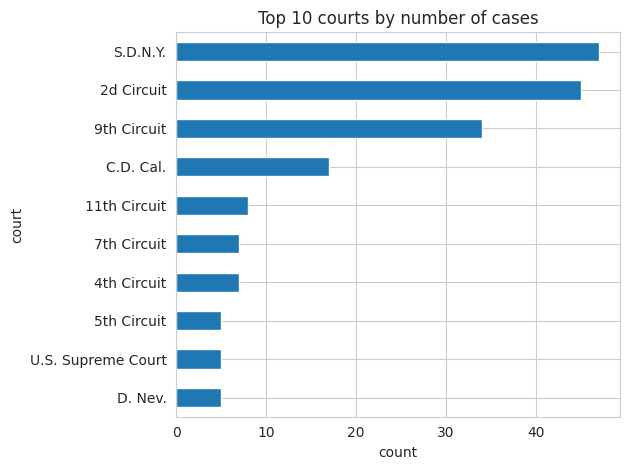

In [65]:
plt.figure(figsize=(7,3))
top_courts.sort_values("count").plot(kind="barh", x="court", y="count", legend=False)
plt.title("Top 10 courts by number of cases")
plt.xlabel("count")
plt.ylabel("court")
plt.tight_layout()
plt.show()

The chart makes the imbalance clear: after the top three, counts fall quickly, so comparisons involving smaller courts will be less reliable due to low sample sizes.

## Part 3: Case Segment Mix and Label Co-occurrence

This section looks at how cases are labeled in each table. `categories` in the cases table and `tags` in the findings table help describe what kinds of works or issues appear most, what is rare, and what areas may be worth deeper investigation.

In [66]:
cats = (fair_use_cases[["case", "fair_use_found", "categories"]]
        .dropna(subset=["categories"])
        .assign(category=fair_use_cases["categories"].astype(str).str.split(r",|;"))
        .explode("category"))

cats["category"] = cats["category"].astype(str).str.strip().str.lower()

top_categories = cats["category"].value_counts().head(15).reset_index()
top_categories.columns = ["category", "count"]
top_categories

,category,count
0,textual work,94
1,film/audiovisual,65
2,photograph,63
3,education/scholarship/research,56
4,internet/digitization,51
5,review/commentary,46
6,news reporting,38
7,parody/satire,34
8,painting/drawing/graphic,31
9,music,27


The dataset is dominated by a few content types, especially Textual work (84), Film/Audiovisual (64), and Photograph (63), with a gradual drop after the top group. This suggests EDA and later analysis should focus on these “high-volume” categories first, since they drive most of the signal.

<Figure size 700x300 with 0 Axes>

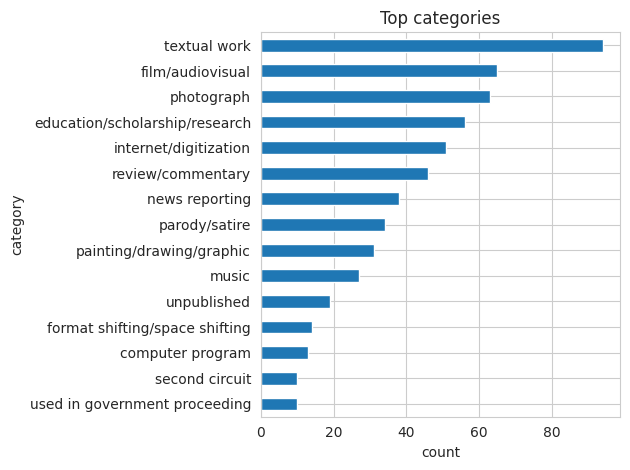

In [67]:
plt.figure(figsize=(7,3))
top_categories.sort_values("count").plot(kind="barh", x="category", y="count", legend=False)
plt.title("Top categories")
plt.xlabel("count")
plt.ylabel("category")
plt.tight_layout()
plt.show()

The chart makes the long-tail pattern clearer: a small set of categories accounts for a large share of cases, while many categories appear relatively rarely, which can make category-level comparisons noisy for smaller groups.

In [68]:
tags = (fair_use_findings[["title", "tags"]]
        .dropna(subset=["tags"])
        .assign(tag=fair_use_findings["tags"].astype(str).str.split(r",|;"))
        .explode("tag"))

tags["tag"] = tags["tag"].astype(str).str.strip().str.lower()

top_tags = tags["tag"].value_counts().head(15).reset_index()
top_tags.columns = ["tag", "count"]
top_tags

,tag,count
0,textual work,95
1,second circuit,79
2,film/audiovisual,65
3,photograph,64
4,education/scholarship/research,57
5,ninth circuit,55
6,internet/digitization,51
7,review/commentary,46
8,news reporting,39
9,parody/satire,34


The tag list overlaps heavily with categories (Textual work, Film/Audiovisual, Photograph), but it also includes court-related tags like Second Circuit (79) and Ninth Circuit (55). That implies tags mix “case type” information with “where the case was decided,” so tags may not be purely topical.

<Figure size 700x300 with 0 Axes>

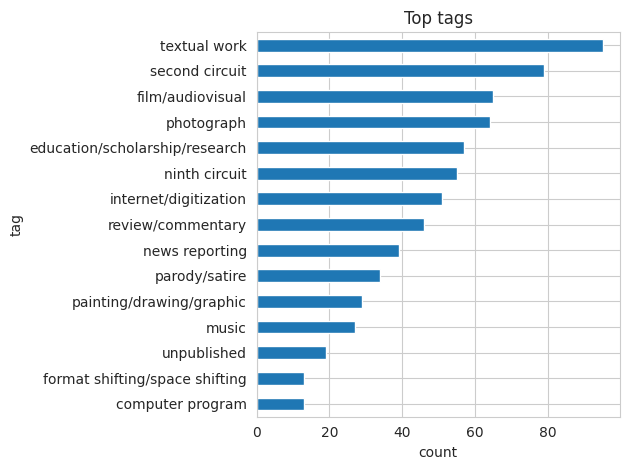

In [69]:
plt.figure(figsize=(7,3))
top_tags.sort_values("count").plot(kind="barh", x="tag", y="count", legend=False)
plt.title("Top tags")
plt.xlabel("count")
plt.ylabel("tag")
plt.tight_layout()
plt.show()


The plot reinforces two points: most tags mirror the main content categories, and court-related tags are among the most frequent. Also, a small data-quality detail shows up: Textual work and Textual Work appear separately, which indicates inconsistent capitalization and a need to standardize labels before deeper tag-based analysis.

## Part 4: Narrative Detail and Text Complexity

Finally, inspect how long the case narratives are and how much they vary, since large differences in length can signal different types of cases or levels of detail.

In [70]:
text_cols = ["key_facts", "issue", "holding"]
for c in text_cols:
    fair_use_findings[c] = fair_use_findings[c].astype(str)
    fair_use_findings[c + "_words"] = fair_use_findings[c].str.split().str.len()

fair_use_findings[[c + "_words" for c in text_cols]].describe()


,key_facts_words,issue_words,holding_words
count,251.000000,251.000000,251.000000
mean,122.195219,22.434263,197.382470
std,50.487441,8.928531,101.760961
min,33.000000,10.000000,4.000000
25%,84.500000,17.000000,121.000000
50%,111.000000,21.000000,173.000000
75%,149.500000,26.000000,269.500000
max,344.000000,109.000000,744.000000


The narrative fields vary a lot in length. On average, key_facts are about 122 words (33 to 344), issue is much shorter at about 22 words (10 to 109), and holding is the longest at about 197 words with a very wide range (4 to 744). The large standard deviation for holdings suggests some cases have extremely detailed writeups compared to others.

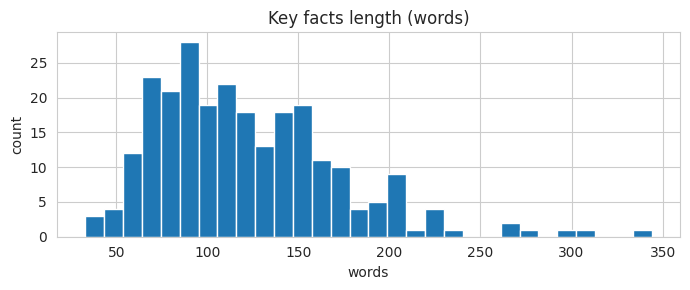

In [71]:
plt.figure(figsize=(7,3))
plt.hist(fair_use_findings["key_facts_words"], bins=30)
plt.title("Key facts length (words)")
plt.xlabel("words")
plt.ylabel("count")
plt.tight_layout()
plt.show()


The key facts length is concentrated in a mid-range (roughly around 70 to 160 words), with a clear right tail showing a smaller number of much longer summaries. That tail matters later because longer texts can dominate similarity or clustering methods if length is not controlled.

In [72]:
fair_use_findings[["title", "key_facts_words"]].nlargest(5, "key_facts_words")

,title,key_facts_words
66,Corbello v. DeVito,344
74,Cambridge University Press v. Mark P. Becker,309
16,"Google LLC v. Oracle Am., Inc.",297
65,"Donald Graham v. Richard Prince, et al.",272
62,"Disney Enterprises, Inc. v. VidAngel, Inc.",267


These cases have the most detailed “key facts” summaries, which signals higher narrative complexity and likely more moving parts in the dispute. They are useful stress tests for later text analysis because their length can dominate similarity measures or clustering if text length is not normalized.

In [73]:
fair_use_findings[["title", "holding_words"]].nlargest(5, "holding_words")

,title,holding_words
3,Am. Soc'y for Testing & Materials v. Public.Re...,744
16,"Google LLC v. Oracle Am., Inc.",734
86,"Cambridge Univ. Press v. Patton,",548
60,"Penguin Random House LLC, et al. v. Frederik C...",454
72,"TCA Television Corp. v. McCollum,",381


These cases contain the most extensive holdings, suggesting especially complex legal reasoning or multi-issue decisions. They highlight clear “extreme cases” in the dataset and should be reviewed when interpreting text-based models, since very long holdings can disproportionately influence themes and embeddings.

In [74]:
stop = {"the","and","to","of","a","in","for","on","with","as","by","at","from","an","or","is","was","are","be","that","this"}

words = (fair_use_findings["holding"].astype(str).str.lower()
         .str.replace(r"[^a-z\s]", " ", regex=True)
         .str.split()
         .explode())

words = words[~words.isin(stop) & words.str.len().ge(3)]

top_words = words.value_counts().head(20).reset_index()
top_words.columns = ["word", "count"]
top_words

,word,count
0,use,1520
1,court,1358
2,fair,815
3,not,608
4,work,543
5,found,487
6,factor,466
7,because,401
8,market,366
9,defendant,353


The most frequent terms are strongly legal and decision-focused (for example, use, court, fair, factor, market, defendant), which confirms the holdings are written in consistent judicial language. This also suggests that later NLP steps should filter generic legal boilerplate (and possibly combine singular/plural forms like defendant/defendants and work/works) to better surface content-specific themes.

# Summary

* **Outcome distribution and imbalance:** Fair use outcomes are moderately imbalanced, with **150 “fair use not found” vs 101 “fair use found.”** This baseline matters for any later comparisons because “not found” is the more common outcome.

* **Outcome variability over time:** The **fair use found rate fluctuates sharply by year**, especially in older years where the rate often hits **0.0 or 1.0**, indicating very small sample sizes in those years. In more recent decades the series is still noisy but tends to stay in a mid-range rather than consistently high or low.

* **Where cases come from (venue concentration):** The data is **highly concentrated in a few courts and circuits**. For courts, **S.D.N.Y. (47), 2d Circuit (45), and 9th Circuit (34)** dominate. For jurisdiction, the **2nd Circuit (98)** and **9th Circuit (64)** account for a large share. This concentration implies venue-specific patterns could drive aggregate results, while smaller venues will be harder to compare reliably.

* **Case types and labeling patterns:** Content categories show a **long-tail distribution** where a few categories dominate: **Textual work (84), Film/Audiovisual (64), Photograph (63), Education/Scholarship/Research (56), Internet/Digitization (50)**. Tags largely mirror these content types, but also include **venue-like tags** such as **Second Circuit (79)** and **Ninth Circuit (55)**, meaning tags mix “what the case is about” with “where it was decided.” This is an important co-occurrence signal: labeling is not purely topical and may partially encode jurisdiction.

* **Text length distributions and outliers:** The narrative fields vary substantially in length:

  * **key_facts:** mean ≈ **122 words** (33 to **344**)
  * **issue:** mean ≈ **22 words** (10 to **109**)
  * **holding:** mean ≈ **197 words** (4 to **744**)

* **Frequent terms and writing style:** The most common words in holdings are strongly legal and decision-focused (e.g., **use, court, fair, factor, market, defendant, plaintiff**), indicating a fairly consistent judicial style across cases. The vocabulary suggests substantial “legal boilerplate,” so later NLP steps would likely benefit from filtering generic legal terms (and normalizing variants like singular/plural forms) to surface more content-specific themes.